In [1]:
%reset -f
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import os
import importlib
import vep_prob_models
import lib.plots.stan
import dyn_model
import retro_prepare_data

/home/anirudh/anaconda3/envs/python3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data_dir = 'datasets/RetrospectivePatients/id004_bj'
results_dir = 'results/exp10/exp10.67/id004_bj'
meta_data_fname = 'BJcrise1le161128B-BEX_0002.json'
raw_seeg_fname = 'BJcrise1le161128B-BEX_0002.raw.fif'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [3]:
obs, consts, params_init = retro_prepare_data.prepare_data_pymc3(data_dir, results_dir, meta_data_fname, raw_seeg_fname, 10, 0.04)

Isotrak not found


In [4]:
obs['slp'] = obs['slp'][0:-1:1024]

obs['snsr_pwr'] = (obs['slp']**2).sum(axis=0)
obs['snsr_pwr'] = obs['snsr_pwr'] / obs['snsr_pwr'].max()
# pickd_snsrs = np.argsort(snsr_pwr)[::-1][0:100]

consts['nt'] = obs['slp'].shape[0]
consts['eps_snsr_pwr'] = 0.01
# consts['gain'] = consts['gain'][pickd_snsrs]

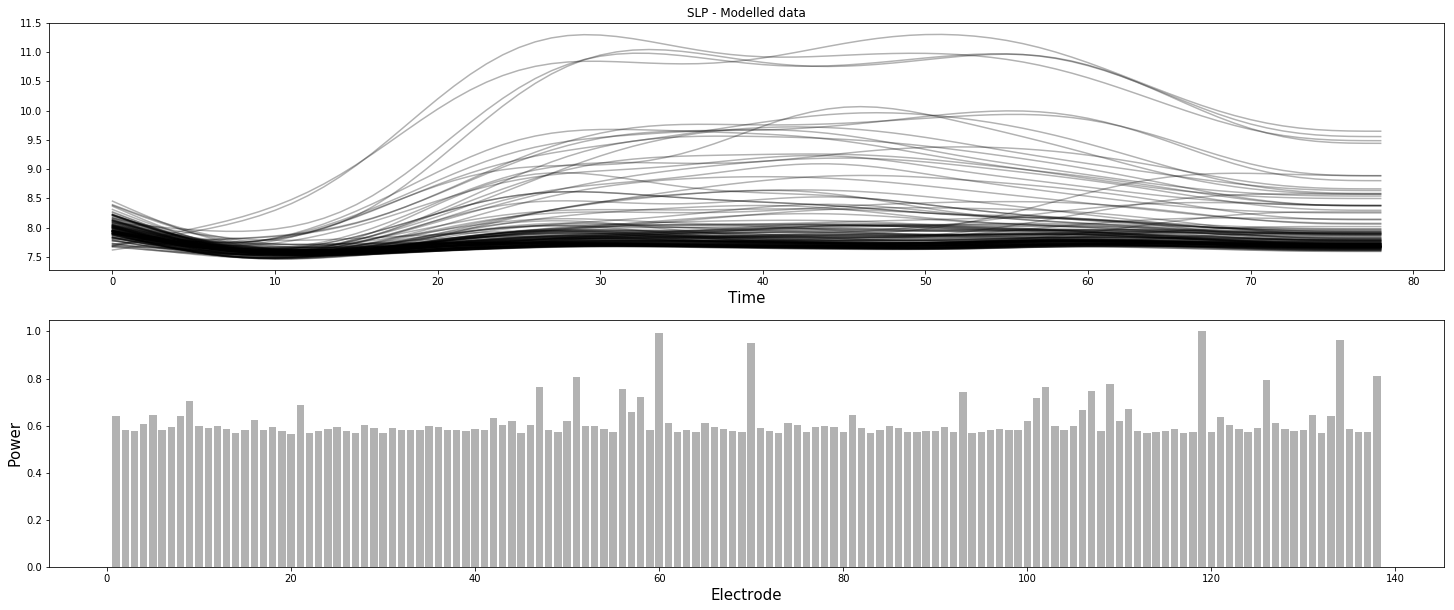

In [5]:
plt.figure(figsize=(25,10))
plt.subplot(211)
plt.plot(obs['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=15)
plt.title('SLP - Modelled data')
plt.subplot(212)
plt.bar(np.arange(1,consts['gain'].shape[0]+1), obs['snsr_pwr'], color='black', alpha=0.3)
plt.xlabel('Electrode', fontsize=15)
plt.ylabel('Power', fontsize=15)
plt.savefig(f'{results_dir}/figures/fitting_data.png')

In [7]:
vep_mdl = vep_prob_models.vep_ode(consts=consts, obs=obs)

In [8]:
niters = 10000
# optmzr = pm.SVGD(n_particles=4, jitter=0.1, temperature=1, model=vep_mdl.model, start=params_init)
# post_approx = optmzr.fit(niters)
trace = pm.sample(draws=500, start=params_init, tune=500, model=vep_mdl.model, chains=1, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [z_init_star, x_init_star, tau0_star, K_star, offset_star, amplitude_star, x0_star]
100%|██████████| 1000/1000 [2:55:59<00:00,  9.48s/it]
There were 419 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.27309950457714005, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
try:
    i = 0
    while(True):
        print(f'Iterations {niters+i*100} - {niters+(i+1)*100}')
        optmzr.refine(100, progressbar=False)
        trace1 = optmzr.approx.sample(1000)
        i += 1
except FloatingPointError as err:
    pass

### Save the trace

In [9]:
save_dir_name = 'samples'
os.makedirs(f'{results_dir}/{save_dir_name}')
pm.backends.save_trace(trace,f'{results_dir}/{save_dir_name}', overwrite=True)

'results/exp10/exp10.67/id004_bj/samples'

In [ ]:
# trace = pm.backends.load_trace(f'{results_dir}', model=vep_mdl.model)
trace = np.load(f'{results_dir}/0/samples.npz')

In [10]:
with vep_mdl.model:
    trace = post_approx.sample(1000)

NameError: name 'post_approx' is not defined

In [ ]:
with vep_mdl.model:
    trace = pm.backends.text.load(results_dir)

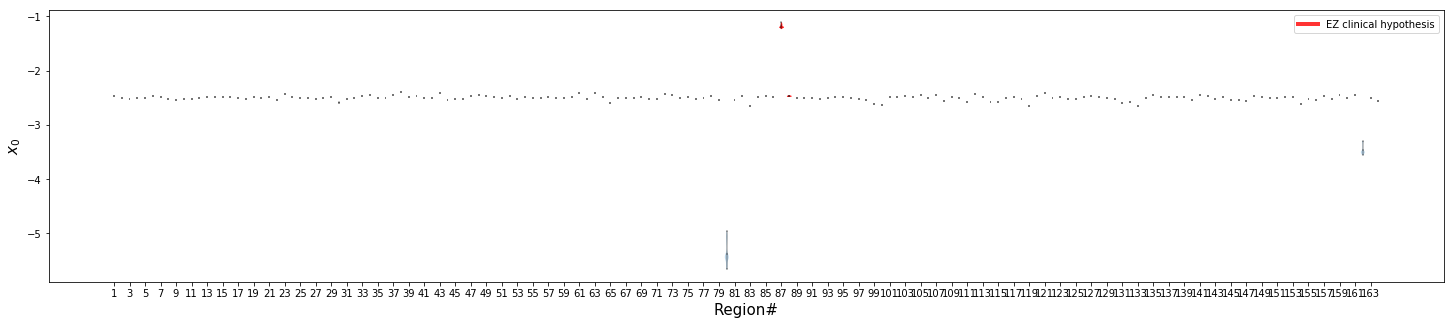

In [11]:
ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0] + 1

lib.plots.stan.x0_violin_patient(trace['x0'], ez_hyp, figsize=(25,5), figname=f'{results_dir}/figures/x0_violin.png')

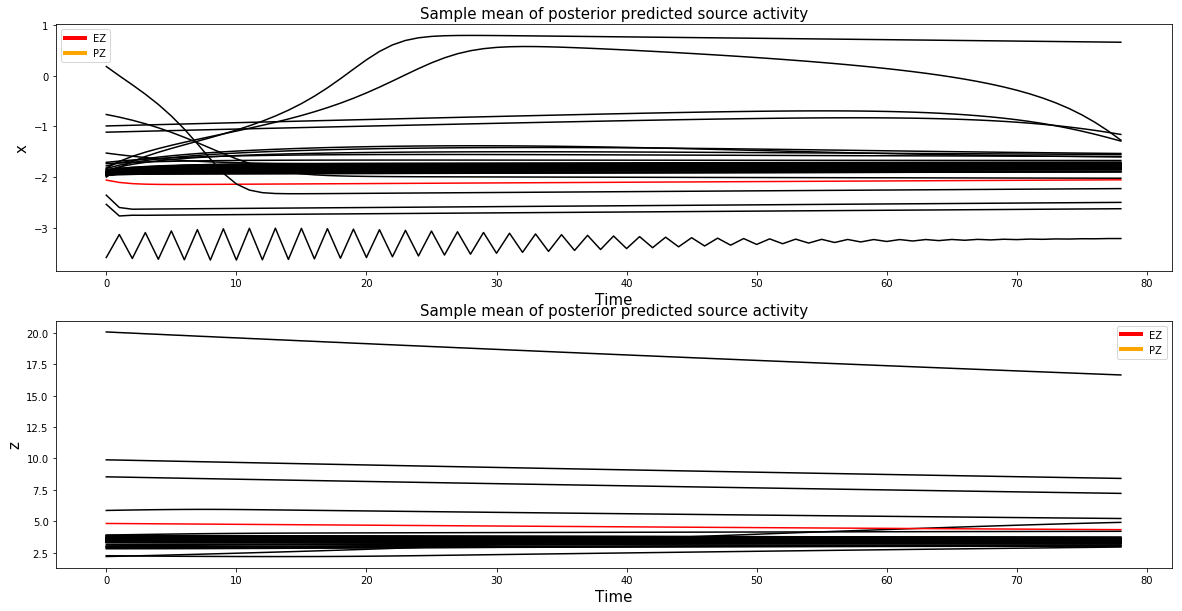

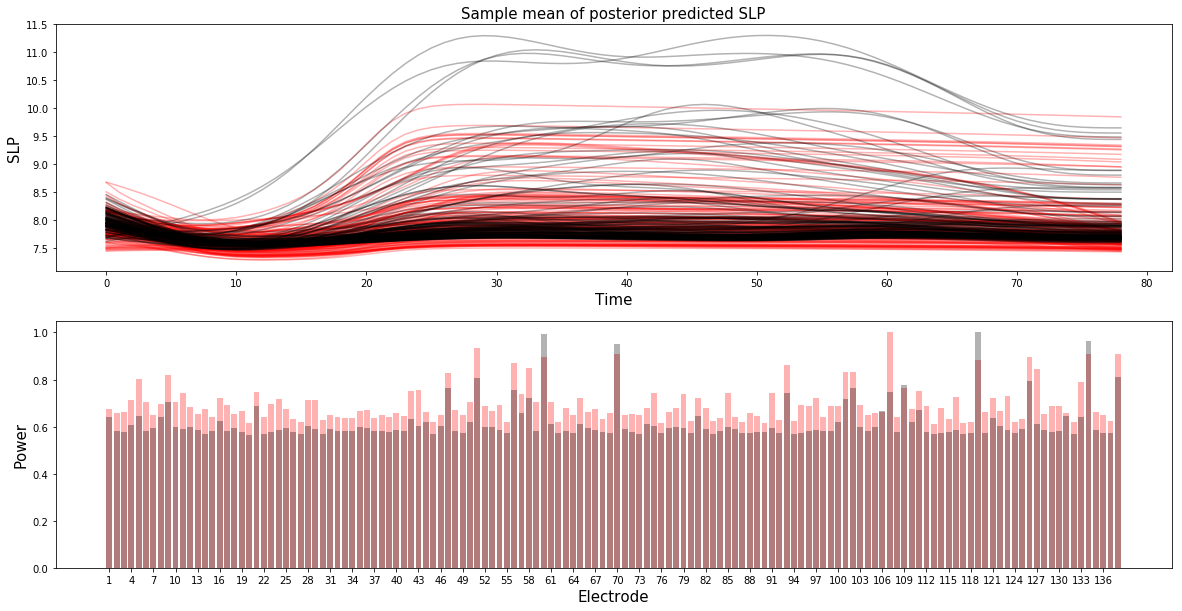

In [17]:
lib.plots.stan.plot_source(trace['x'].mean(axis=0), trace['z'].mean(axis=0), ez_hyp, [], figname=f'{results_dir}/posterior_predicted_src.png')
lib.plots.stan.plot_fit_target({'slp':trace['mu_slp'].mean(axis=0), 'snsr_pwr':trace['mu_snsr_pwr'].mean(axis=0)}, obs, figname=f'{results_dir}/posterior_predicted_slp.png')
# plt.figure(figsize=(25,5))
# plt.plot(trace['mu_slp'].mean(axis=0), 'r', alpha=0.3);
# plt.plot(obs['slp'], 'k', alpha=0.3);
# plt.figure(figsize=(25,5))
# plt.plot(trace['mu_snsr_pwr'].mean(axis=0).T, 'r', alpha=0.1)
# plt.plot(obs['snsr_pwr'].T, 'k', alpha=0.3)

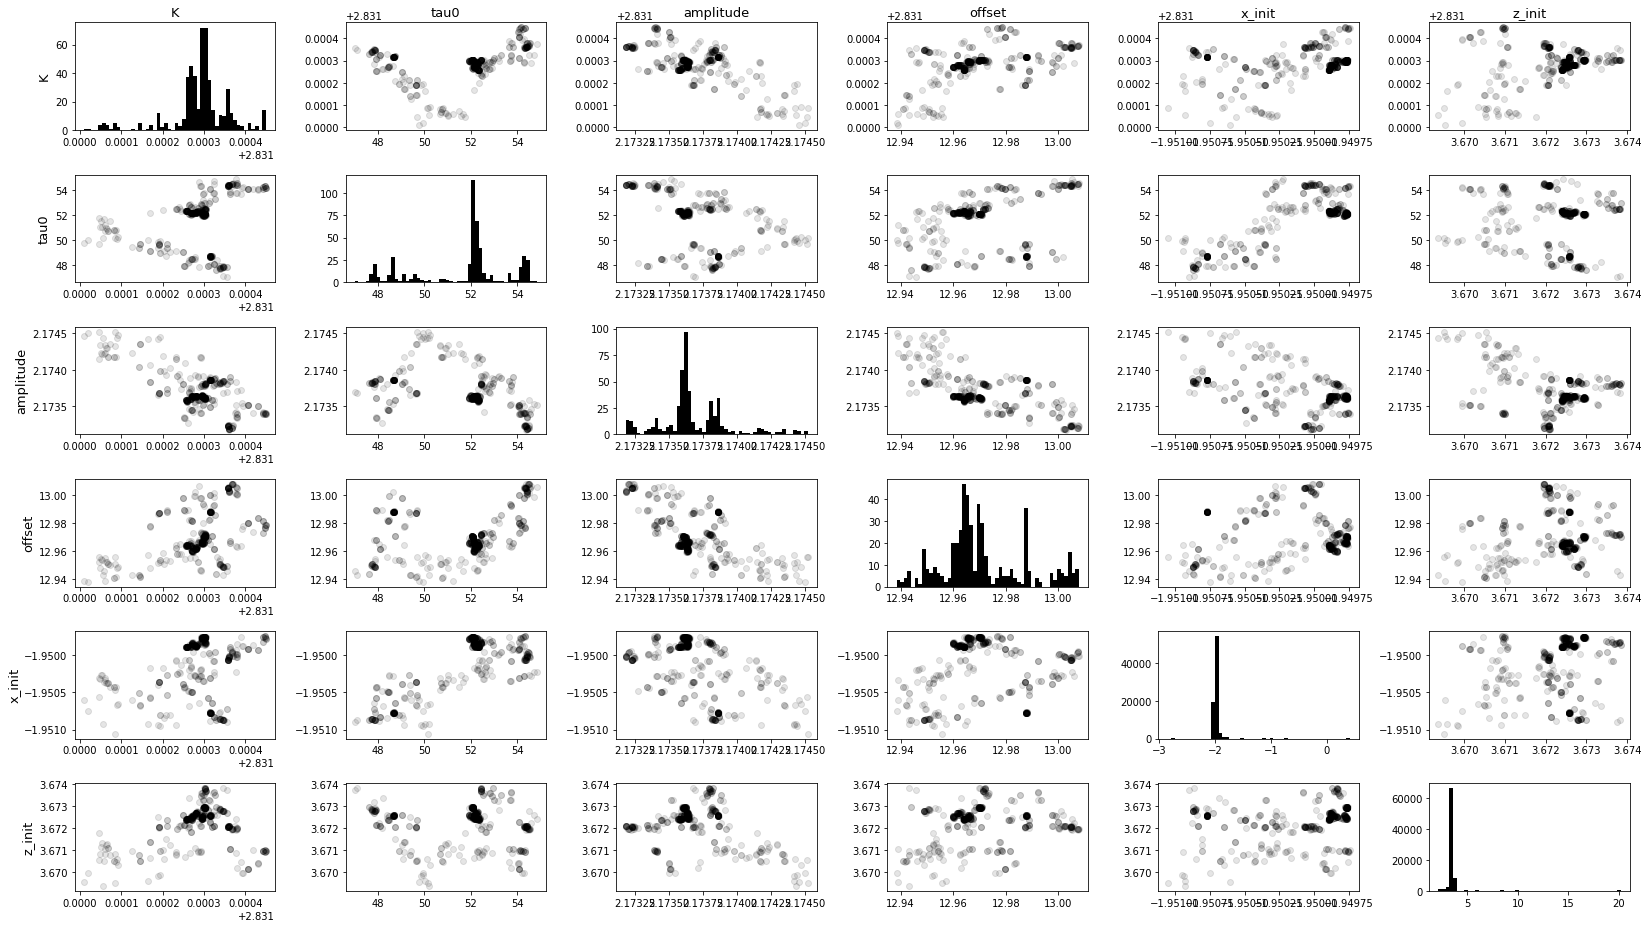

In [13]:
lib.plots.stan.pair_plots(trace, ['K', 'tau0', 'amplitude', 'offset', 'x_init', 'z_init'])

In [ ]:
post_pred = pm.sample_posterior_predictive(trace1, model=vep_mdl.model)

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(post_pred['slp'][20], 'r', alpha=0.3);
plt.plot(obs['slp'], 'k', alpha=0.3);
plt.figure(figsize=(25,5))
plt.bar(np.r_[0:consts['ns']], obs['snsr_pwr'], color='black', alpha=0.3)
plt.bar(np.r_[0:consts['ns']], trace1['mu_snsr_pwr'].mean(axis=0), color='red', alpha=0.5)

In [ ]:
ep = dyn_model.Epileptor_2D()
params = dict()
params['nn'] = consts['nn']
params['nt'] = consts['nt']
params['x_init'] = consts['x_init']
params['z_init'] = consts['z_init']
params['time_step'] = consts['time_step']
params['I1'] = consts['I1']
params['SC'] = consts['SC']
x = np.zeros((trace['x0'].shape[0], consts['nt'], consts['nn']))
z = np.zeros((trace['x0'].shape[0], consts['nt'], consts['nn']))
slp = np.zeros((trace['x0'].shape[0], consts['nt'], consts['ns']))
for i in range(trace['x0'].shape[0]):
    params['tau0'] = trace['tau0'][i]
    params['K'] = trace['K'][i]
    params['x0'] = trace['x0'][i]
    sim_out = ep.sim(params)
    x[i] = sim_out['x']
    z[i] = sim_out['z']
    slp[i] = trace['amplitude'][i]*(np.log(consts['gain']@np.exp(x[i].T)) + trace['offset'][i]).T

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(slp.mean(axis=0), 'k', alpha=0.3);